# The Time Machine, identify drought events

In [1]:
# !pip install numpy xarray netCDF4 matplotlib plotly
# !pip install "dask[complete]" -q
# !pip install geopy ipywidgets folium -q
# !pip install pycountry -q
# !pip install shapely
# !pip install -U kaleido
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [2]:
from ipywidgets import Layout, Dropdown, widgets
from IPython.display import display, clear_output, IFrame
from functools import partial
import datetime
import numpy as np
import utils.widgets_handler as widgets_handler
import utils.coordinates_retriver as coordinates_retriver
import utils.data_preprocess as data_preprocess
import utils.charts as charts
import warnings
import hvplot.xarray
import cartopy.crs as ccrs
warnings.filterwarnings("ignore", category=RuntimeWarning)

ModuleNotFoundError: No module named 'dask'

In [29]:
country_list = widgets_handler.read_json_to_sorted_dict('countries.json')
months = widgets_handler.read_json_to_dict('months.json')
timescales = widgets_handler.read_json_to_dict('timescales.json')
subset_area = None
index = None
bounding_box = (None, None, None, None)
active_btn = None

selected = {
    "country": None,
    "adm1_subarea": None,
    "adm2_subarea": None,
    "timescale": None,
    "month": None,
    "year": None,
    "year_range": None
}

placeholders = {
    "country": "no country selected...",
    "adm1_subarea": "no adm1 subarea selected...",
    "adm2_subarea": "no adm2 subarea selected...",
    "timescale": "no timescale selected...",
    "month": "no month selected...",
    "year": "no year selected..."
}
widgets_handler.save_selection(placeholders)

In [30]:
# Custom style and layout for descriptions and dropdowns
style = {'description_width': '150px'}
dropdown_layout = Layout(width='400px', display='flex', justify_content='flex-end')
range_layout = Layout(width='400px')
btn_layout = Layout(width='400px')


# Dropdown for countries
country_names = [country['name'] for country in country_list]
country_selector = widgets.Dropdown(
    options=[placeholders['country']] + country_names,
    description='Select a country:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for subareas, initially empty
adm1_subarea_selector = widgets.Dropdown(
    options=[placeholders['adm1_subarea']],
    description='a subarea of first level:',
    style=style,
    layout=dropdown_layout
)

adm2_subarea_selector = widgets.Dropdown(
    options=[placeholders['adm2_subarea']],
    description='or of second level:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for timescales
timescale_selector = widgets.Dropdown(
    options=[placeholders['timescale']] + list(timescales.keys()),
    description='Select a timescale:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for months
month_selector = widgets.Dropdown(
    options=[placeholders['month']] + list(months.keys()),
    description='Select a month:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for years
current_year = datetime.datetime.now().year
years_options = [str(year) for year in range(1940, current_year + 1)]

year_selector = widgets.Dropdown(
    options=[placeholders['year']] + years_options,
    description='Select a year:',
    disabled=False,
    style=style,
    layout=dropdown_layout
)

# SelectionRangeSlider for years
year_range_selector = widgets.SelectionRangeSlider(
    options=years_options,
    index=(len(years_options) - 1, len(years_options) - 1),  # Start and end at the last
    description='Select the year range:',
    disabled=False,
    style=style,
    layout=range_layout
)

selectors = {
    "country" : country_selector,
    "adm1_subarea": adm1_subarea_selector,
    "adm2_subarea": adm2_subarea_selector,
    "timescale": timescale_selector,
    "month": month_selector,
    "year": year_selector,
    "year_range": year_range_selector    
}


month_widgets_btn = widgets.Button(
    description='Get data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='filter', # (FontAwesome names without the `fa-` prefix)month
    layout=btn_layout
)
month_widgets_btn.custom_name='month_widgets_btn'


year_widgets_btn = widgets.Button(
    description='Get data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='filter', # (FontAwesome names without the `fa-` prefix)
    layout=btn_layout
)
year_widgets_btn.custom_name='year_widgets_btn'

year_range_widgets_btn = widgets.Button(
    description='Get data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='filter', # (FontAwesome names without the `fa-` prefix)
    layout=btn_layout
)
year_range_widgets_btn.custom_name='year_range_widgets_btn'

# Output area for display updates
output_area = widgets.Output()

In [31]:
def setup_observers():
    """
    Sets up observers for UI widgets to handle interactions and updates dynamically in a graphical user interface.
    This function ensures that observers are only set once using a function attribute to track whether observers have
    already been established, enhancing efficiency and preventing multiple bindings to the same event.

    Observer is attached to widgets for country selection. This observer triggers specific functions when the 'value' property 
    of the widgets changes, facilitating responsive updates to the user interface
    based on user interactions.

    Notes:
    - This function uses a custom attribute `observers_set` on itself to ensure observers are set only once.
    """
    if not hasattr(setup_observers, 'observers_set'):      
            # When 'value' changes, update_subareas function will be called to update the dropdown menus
            # Create a partial function that includes the additional parameters
            country_selector.observe(partial(widgets_handler.update_subareas, 
                                         country_list=country_list, 
                                         placeholders=placeholders,
                                         adm1_subarea_selector=adm1_subarea_selector, 
                                         adm2_subarea_selector=adm2_subarea_selector), 'value')
            # Set a flag to indicate observers are set
            setup_observers.observers_set = True


            

def update_and_get_data(btn_name):
    """
    Update and retrieve data based on user interactions and selections.

    This function handles user interactions, validates selections, calculates geographic bounding boxes,
    fetches the corresponding data subset, and updates the output area with relevant information and a map display.

    Parameters:
    btn_name (str): The name of the button that triggered the interaction.

    Global Variables:
    selected (dict): Dictionary containing current selections for various parameters.
    placeholders (dict): Dictionary of placeholder values.
    output_area (OutputArea): The output area widget to display messages and results.
    subset_data (xarray.DataArray): Subset of data fetched based on the bounding box.
    index (str): Index for the subset data, constructed from timescale value.
    bounding_box (tuple): Bounding box coordinates (min_lon, min_lat, max_lon, max_lat) for the selected area.
    active_btn (str): The name of the currently active button.

    Steps:
    1. Set the active button name.
    2. Update the month and year selections based on the button interaction.
    3. Validate the current selections.
    4. If selections are valid:
       a. Clear the output area.
       b. Retrieve the geographic boundaries for the selected area.
       c. Calculate the bounding box for the selected area.
       d. Fetch the data subset based on the bounding box.
       e. Determine the administrative level, selected area name, timescale, and time period.
       f. Print information about the uploaded subset data.
       g. Display the map with the bounding box and appropriate zoom level.


    Notes:
    - The function assumes the existence of utility functions within the 'uti' module for handling interactions, validations, 
      data fetching, and map display.
    - The global variables should be properly initialized before calling this function.
    """
    global selected, placeholders, output_area, subset_data, index, bounding_box, active_btn
    map_display = None
    active_btn = btn_name
    widgets_handler.month_year_interaction(btn_name, month_selector, year_selector, selected, placeholders)
    if widgets_handler.validate_selections(btn_name, selected, selectors, placeholders, output_area):
        with output_area:
            output_area.clear_output(wait=True)
            coordinates = coordinates_retriver.get_boundaries(selected, country_list, placeholders)
            # print(coordinates)
            bounding_box = coordinates_retriver.calculate_bounding_box(coordinates)
            # print(bounding_box)            
                        
            # sample_coordinates = coordinates[:3] # Showing first 3 coordinates for brevity            
            # print('Original Coordinates Sample: ', sample_coordinates)  
            # print('Bounding Box: ', bounding_box)
                        
            # Fetching data using the bounding box
            subset_data = data_preprocess.get_xarray_data(btn_name, bounding_box, selectors, placeholders, months, timescales)
            index = f"SPEI{timescales[selectors['timescale'].value]}"
            adm_level, selected_area = widgets_handler.get_adm_level_and_area_name(selected, placeholders)
            timescale = selected['timescale']
            time_period = widgets_handler.get_period_of_time(btn_name, selected, placeholders)
                
            print(f"SPEI subset data uploaded for {selected_area}, administrative level {adm_level}, timescale {timescale}, period {time_period}")
            zoom_start = 4
            if adm_level == 'ADM1' or adm_level == 'ADM2':
                zoom_start = 8  
            map_display = coordinates_retriver.display_map(bounding_box, zoom_start)
            map_iframe = coordinates_retriver.display_map_in_iframe(map_display)
            display(map_iframe)

            
# Set up widget interaction
def on_button_clicked(btn):
    update_and_get_data(btn.custom_name)


# Setup observers
setup_observers()

In [32]:
# Update existing selectors
subset_data = None
previous_selection = widgets_handler.read_json_to_dict('selection.json')

# Set up widgets with previous settings
country_selector.value = previous_selection.get('country', placeholders['country'])
adm1_subarea_selector.value = previous_selection.get('adm1_subarea', placeholders['adm1_subarea'])
adm2_subarea_selector.value = previous_selection.get('adm2_subarea', placeholders['adm2_subarea'])
timescale_selector.value = previous_selection.get('timescale', placeholders['timescale'])
month_selector.value = previous_selection.get('month', placeholders['month'])
month_widgets_btn.on_click(on_button_clicked)

# Display widgets
display(country_selector, adm1_subarea_selector, adm2_subarea_selector, timescale_selector, month_selector, month_widgets_btn, output_area)

Dropdown(description='Select a country:', layout=Layout(display='flex', justify_content='flex-end', width='400…

Dropdown(description='a subarea of first level:', layout=Layout(display='flex', justify_content='flex-end', wi…

Dropdown(description='or of second level:', layout=Layout(display='flex', justify_content='flex-end', width='4…

Dropdown(description='Select a timescale:', layout=Layout(display='flex', justify_content='flex-end', width='4…

Dropdown(description='Select a month:', layout=Layout(display='flex', justify_content='flex-end', width='400px…

Button(button_style='info', description='Get data', icon='filter', layout=Layout(width='400px'), style=ButtonS…

Output()

In [42]:
if not subset_data:
    selected = {
        "country": 'Greece',
        "adm1_subarea": None,
        "adm2_subarea": None,
        "timescale": '6 months',
        "month": 'June',
        "year": None,
        "year_range": None
    }
    selectors = {
    "country" : country_selector,
    "adm1_subarea": adm1_subarea_selector,
    "adm2_subarea": adm2_subarea_selector,
    "timescale": timescale_selector,
    "month": month_selector,
    "year": year_selector,
    "year_range": year_range_selector    
}
    coordinates = coordinates_retriver.get_boundaries(selected, country_list, placeholders)
            # print(coordinates)
    bounding_box = coordinates_retriver.calculate_bounding_box(coordinates)
    timescale_selector.value = selected['timescale']
    country_selector.value = selected['country']
    month_selector.value = selected['month']
    timescale = selected['timescale']
    index = f"SPEI{timescales[selectors['timescale'].value]}"
    subset_data = data_preprocess.get_xarray_data('month_widgets_btn', bounding_box, selectors, placeholders, months, timescales)
data_preprocess.display_data_details('month_widgets_btn', selected, subset_data[index])

Country:  Italy
ADM1 subarea:  no adm1 subarea selected...
ADM2 subarea:  no adm2 subarea selected...
Month:  January
Timescale:  1 month 

Time values in the subset: 86
Latitude values in the subset: 47
Longitude values in the subset: 48 

Data sample:  [[0.65087384 0.56843294 0.59417689 0.53633146 0.52104073]
 [0.85870783 0.88981189 0.80478525 0.78766646 0.80362451]
 [1.07243577 1.15477214 1.16270983 1.14461253 1.16399736]
 [1.2120848  1.30863014 1.38454161 1.45738932 1.47294426]
 [1.25195178 1.30156042 1.51925645 1.58850551 1.55541797]]


In [43]:
processed_subset, change_summary = data_preprocess.process_datarray(subset_data[index])
print(processed_subset, '\n')
print('Change summary:')
for key, val in change_summary.items():
    print(key, val)

<xarray.DataArray 'SPEI1' (time: 85, lat: 47, lon: 48)> Size: 2MB
dask.array<getitem, shape=(85, 47, 48), dtype=float64, chunksize=(1, 47, 48), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 384B 6.75 7.0 7.25 7.5 7.75 ... 17.75 18.0 18.25 18.5
  * lat      (lat) float64 376B 35.5 35.75 36.0 36.25 ... 46.25 46.5 46.75 47.0
  * time     (time) datetime64[ns] 680B 1940-01-01T06:00:00 ... 2024-01-01T06...
Attributes:
    long_name:  Standardized Drought Index (SPEI1)
    units:      - 

Change summary:
invalid_values_replaced 88322
invalid_ratio 45.52
duplicates_removed 1
cftime_conversions 0


In [44]:
# Convert datetime objects to strings and extract the year for the slider labels
maps_year_labels = {i: str(processed_subset.time.values[i].astype('datetime64[Y]')) for i in range(len(processed_subset.time))}

maps_year_slider = widgets.SelectionSlider(
    options=[(maps_year_labels[i], i) for i in range(len(maps_year_labels))],
    value=0,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Use a lambda to pass both ds (processed_subset) and time_index to the function
maps_year_slider_plot = widgets.interactive(lambda time_index: charts.plot_spei_geographical_distribution(processed_subset, time_index), time_index=maps_year_slider)
display(maps_year_slider_plot)

interactive(children=(SelectionSlider(continuous_update=False, description='Year:', options=(('1940', 0), ('19…

In [ ]:


processed_subset.hvplot(groupby="time",
                        clim=(-8,8),
                        widget_type="scrubber", 
                        widget_location="bottom", 
                        projection=ccrs.PlateCarree(), 
                        coastline='10m',
                       # cnorm='eq_hist',
                       cmap='BrBG')

In [45]:
stat_values = data_preprocess.compute_stats(processed_subset)

In [46]:
charts.create_scatterplot(stat_values, timescales, selected, placeholders)

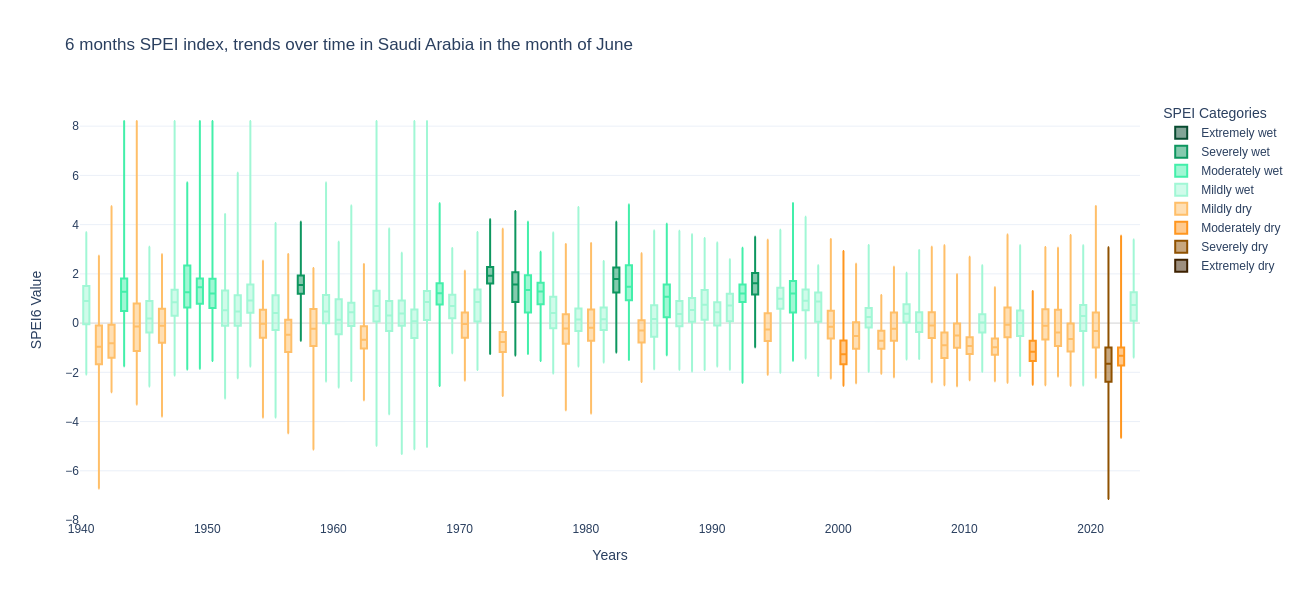

In [11]:
charts.create_boxplot(stat_values, timescales, selected, placeholders)

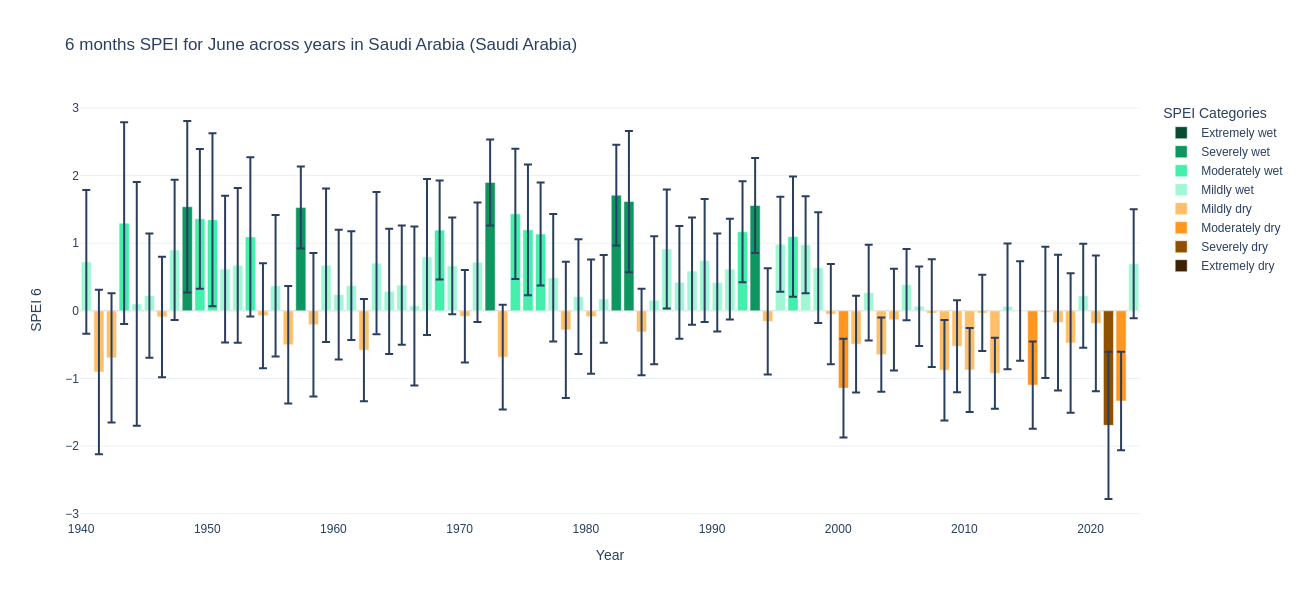

In [16]:
charts.create_std_dev_bar_chart(stat_values, timescales, selected, placeholders)

In [13]:
# Update existing selectors
previous_selection = widgets_handler.read_json_to_dict('selection.json')

# Set up widgets with previous settings
country_selector.value = previous_selection.get('country', placeholders['country'])
adm1_subarea_selector.value = previous_selection.get('adm1_subarea', placeholders['adm1_subarea'])
adm2_subarea_selector.value = previous_selection.get('adm2_subarea', placeholders['adm2_subarea'])
timescale_selector.value = previous_selection.get('timescale', placeholders['timescale'])
year_selector.value = previous_selection.get('year', placeholders['year'])
year_widgets_btn.on_click(on_button_clicked)

# Display widgets
display(country_selector, adm1_subarea_selector, adm2_subarea_selector, timescale_selector, year_selector, year_widgets_btn, output_area)

Dropdown(description='Select a country:', index=170, layout=Layout(display='flex', justify_content='flex-end',…

Dropdown(description='a subarea of first level:', layout=Layout(display='flex', justify_content='flex-end', wi…

Dropdown(description='or of second level:', layout=Layout(display='flex', justify_content='flex-end', width='4…

Dropdown(description='Select a timescale:', index=3, layout=Layout(display='flex', justify_content='flex-end',…

Dropdown(description='Select a year:', layout=Layout(display='flex', justify_content='flex-end', width='400px'…

Button(button_style='info', description='Get data', icon='filter', layout=Layout(width='400px'), style=ButtonS…

Output(outputs=({'name': 'stdout', 'text': 'Coordinates retrieved for Saudi Arabia (ADM0) - https://www.geobou…

In [12]:
data_preprocess.display_data_details(active_btn, selected, subset_data[index])

Country:  Israel
ADM1 subarea:  no adm1 subarea selected...
ADM2 subarea:  Golan
Year:  1995
Timescale:  3 months 

Time values in the subset: 12
Latitude values in the subset: 3
Longitude values in the subset: 3 

Data sample:  [[1.34511606 1.54849556 1.56422204]
 [1.29622062 1.44720167 1.62850052]
 [1.41875685 1.3545634  1.53487496]]


In [13]:
processed_subset, change_summary = data_preprocess.process_datarray(subset_data[index])
print(processed_subset, '\n')
print('Change summary:')
for key, val in change_summary.items():
    print(key, val)

<xarray.DataArray 'SPEI3' (time: 12, lat: 3, lon: 3)>
dask.array<where, shape=(12, 3, 3), dtype=float64, chunksize=(1, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T06:00:00 ... 1995-12-01T06:00:00
  * lon      (lon) float64 35.5 35.75 36.0
  * lat      (lat) float64 32.75 33.0 33.25
Attributes:
    long_name:  Standardized Drought Index (SPEI3)
    units:      - 

Change summary:
invalid_values_replaced 0
invalid_ratio 0.0
duplicates_removed 0
cftime_conversions 0


In [14]:
stat_values = data_preprocess.compute_stats(processed_subset, full_stats=False)

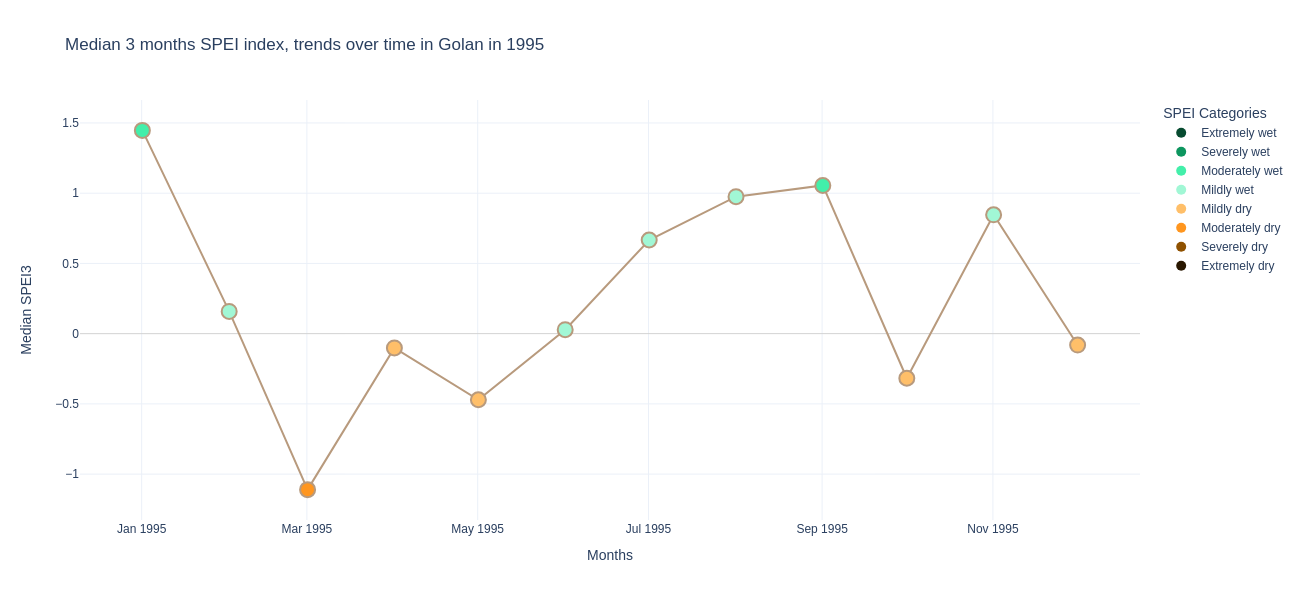

In [15]:
charts.create_linechart(stat_values, timescales, selected, placeholders)

In [16]:
# Update existing selectors
previous_selection = widgets_handler.read_json_to_dict('selection.json')

# Set up widgets with previous settings
country_selector.value = previous_selection.get('country', placeholders['country'])
adm1_subarea_selector.value = previous_selection.get('adm1_subarea', placeholders['adm1_subarea'])
adm2_subarea_selector.value = previous_selection.get('adm2_subarea', placeholders['adm2_subarea'])
timescale_selector.value = previous_selection.get('timescale', placeholders['timescale'])
year_range_selector.value = previous_selection.get('year_range')
year_range_widgets_btn.on_click(on_button_clicked)

# Display widgets
display(country_selector, adm1_subarea_selector, adm2_subarea_selector, timescale_selector, year_range_selector, year_range_widgets_btn, output_area)

Dropdown(description='Select a country:', index=92, layout=Layout(display='flex', justify_content='flex-end', …

Dropdown(description='a subarea of first level:', layout=Layout(display='flex', justify_content='flex-end', wi…

Dropdown(description='or of second level:', index=4, layout=Layout(display='flex', justify_content='flex-end',…

Dropdown(description='Select a timescale:', index=2, layout=Layout(display='flex', justify_content='flex-end',…

SelectionRangeSlider(description='Select the year range:', index=(84, 84), layout=Layout(width='400px'), optio…

Button(button_style='info', description='Get data', icon='filter', layout=Layout(width='400px'), style=ButtonS…

Output(outputs=({'name': 'stdout', 'text': 'Coordinates retrieved for Golan (ADM2) - https://www.geoboundaries…

In [17]:
data_preprocess.display_data_details(active_btn, selected, subset_data[index])

Country:  Israel
ADM1 subarea:  no adm1 subarea selected...
ADM2 subarea:  Golan
Year range:  ('2005', '2024')
Timescale:  3 months 

Time values in the subset: 232
Latitude values in the subset: 3
Longitude values in the subset: 3 

Data sample:  [[-0.01584989  0.00781212 -0.04231642]
 [-0.57952165 -0.47099733 -0.47070313]
 [-0.01546828  0.11126772  0.03528217]]


In [18]:
processed_subset, change_summary = data_preprocess.process_datarray(subset_data[index])
print(processed_subset, '\n')
print('Change summary:')
for key, val in change_summary.items():
    print(key, val)

<xarray.DataArray 'SPEI3' (time: 230, lat: 3, lon: 3)>
dask.array<getitem, shape=(230, 3, 3), dtype=float64, chunksize=(1, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01T06:00:00 ... 2024-02-01T06:00:00
  * lon      (lon) float64 35.5 35.75 36.0
  * lat      (lat) float64 32.75 33.0 33.25
Attributes:
    long_name:  Standardized Drought Index (SPEI3)
    units:      - 

Change summary:
invalid_values_replaced 0
invalid_ratio 0.0
duplicates_removed 2
cftime_conversions 4


In [19]:
stat_values = data_preprocess.compute_stats(processed_subset, full_stats=False)

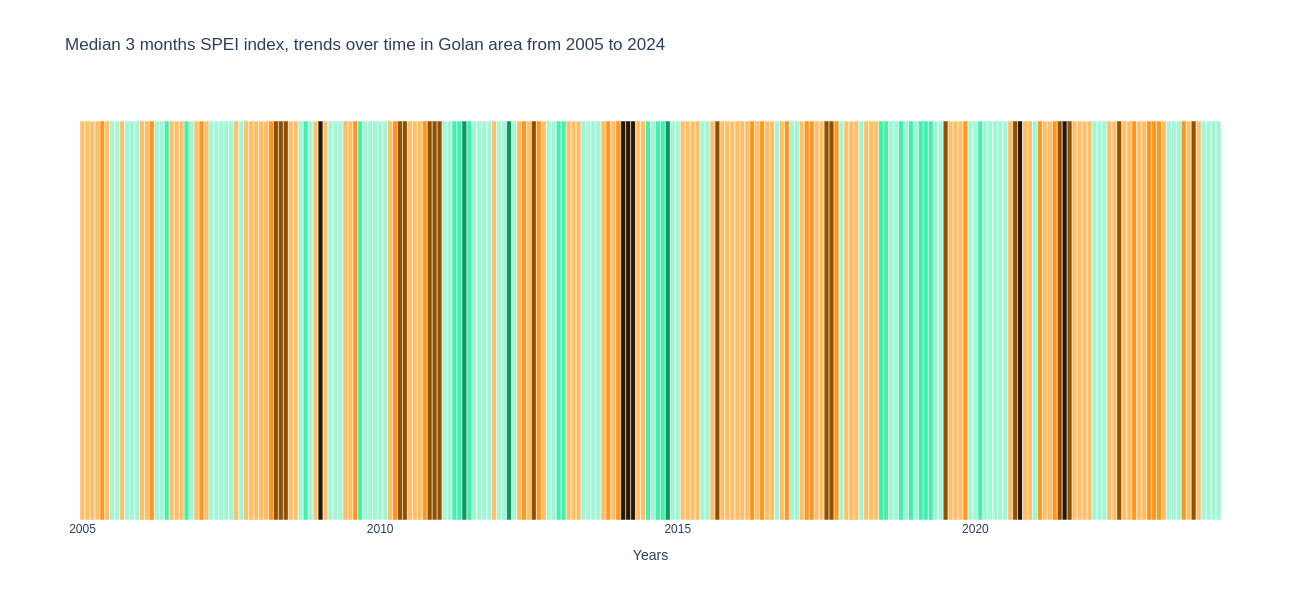

In [20]:
charts.create_stripechart(stat_values, timescales, selected, placeholders)

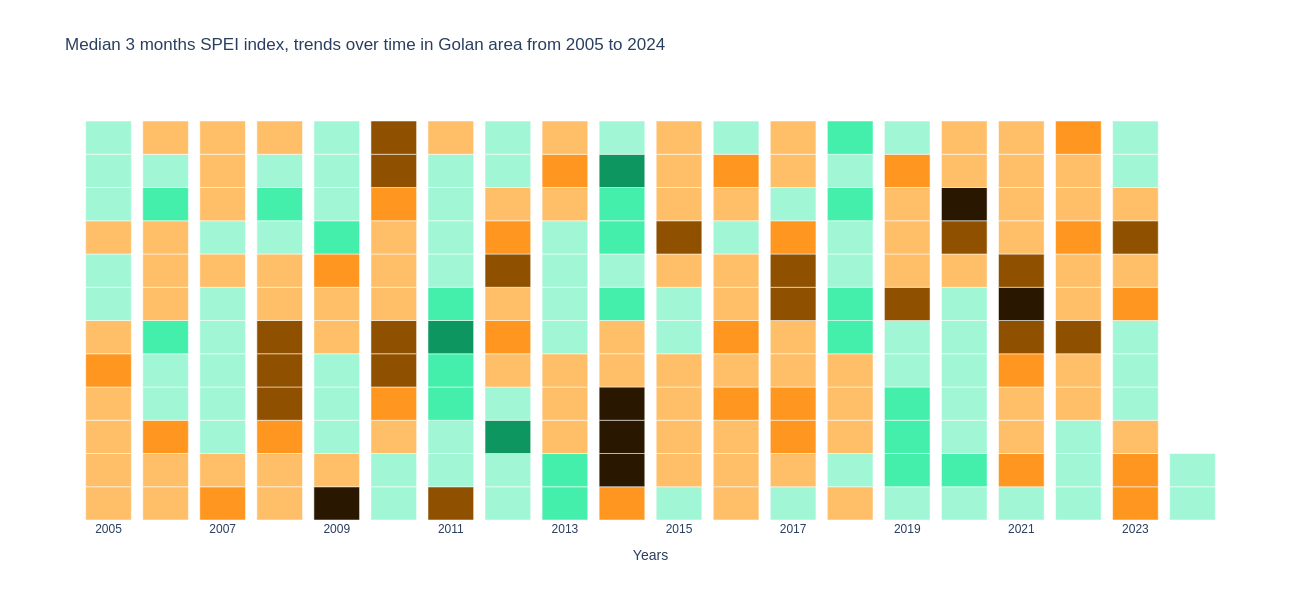

In [21]:
charts.create_stripechart(stat_values, timescales, selected, placeholders, 'year')

countries' boundaries source: www.geoboundaries.org